# Introduction

Hi! My name is Caroline and I will be teaching you how to work with NBA play-by-play data in this tutorial! I want to demonstrate how you can use play-by-play data to calculate statistics and essential data science components for data analysis in the NBA. Specifically, I will be conducting analysis into the _______. 

A "play" in basketball is any sort of event that happens during the game such as a team scoring, rebounding a ball, or substituting a player. Essentially, it includes any event that could be of statistical significance, all in one dataset! These events are recorded along with useful information such as the players involved, current lineup for both teams, and a time stamp of when the event occured.

# Why NBA Play-By-Play Data?

Given all the widely available team and individual statistics spanning the NBA, one may wonder the reason behind analyzing play-by-play data. 

The truth is, many of the advanced statistics used by the NBA and its teams today are derived from play-by-play datasets.

If you're interesting in going in to basketball analytics, learning how to work with play-by-play data is crucial for your skillset!

# The Play-By-Play Dataset

In this tutorial, I will be utilizing an extended NBA Play-By-Play Dataset from https://eightthirtyfour.com/data which tracks the 2018-2019 season.

This dataset contains plays for all 1230 regular season games which includes more than 500,000 entries.

Using this data, I am looking to analyze a team's performance in advanced statistics in wins vs losses!

# Libraries

We will be using the following libraries to conduct our analysis.

In [22]:
import numpy as np
import pandas as pd
import warnings
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
warnings.filterwarnings('ignore')

# Processing the Data

First, let's read in the CSV of the play-by-play data. We will store this data in a Pandas DataFrame.

In [2]:
plays = pd.read_csv('fixed_2018-2019_pbp.csv', low_memory = False)

As a Bay Area native and longtime fan of the Warriors, I will be analyzing all of the Warriors games for this season!

We can select all Warriors games from the dataset using the following indexing which allows us to subset the dataframe using a boolean equation.

In [3]:
# Choosing Team 
warriorsGames = plays[(plays["HOME_TEAM"] == "Warriors") |
                   (plays["AWAY_TEAM"] == "Warriors")]

In the dataset, the score of each team at the time of the play is stored in the columns `HOME_SCORE` and `AWAY_SCORE`. We have to look at the columns `HOME_TEAM` and `AWAY_TEAM` to deduce whose score it is.

To make our lives easier, let's add a separate column called `WARRIORS_SCORE` and `OPPONENT_SCORE` so that can quickly index the team's score. 

There are multiple ways to create new columns with pandas, but I chose to use a list comprehension for readability as shown below.

In [4]:
# Adding Columns for Warriors and Opponent Score
warriorsGames["WARRIORS_SCORE"] = [warriorsGames["HOME_SCORE"].iloc[i] 
                     if (warriorsGames['HOME_TEAM'].iloc[i] == "Warriors") 
                     else warriorsGames['AWAY_SCORE'].iloc[i] 
                     for i in range(len(warriorsGames))]
warriorsGames["OPPONENT_SCORE"] = [warriorsGames["HOME_SCORE"].iloc[i]
                        if (warriorsGames['HOME_TEAM'].iloc[i] != "Warriors")
                        else warriorsGames['AWAY_SCORE'].iloc[i]
                        for i in range(len(warriorsGames))]

In basketball analytics, one useful thing to look at is the difference in teams' performances in games they win and lose. By looking at certain statistics, we can try and identify the factors that lead to wins and losses. 

Therefore, I will split the Warrior's plays/games by wins and losses.

Since this is play-by-play data, we can't directly access which team won and lost. Below, I case on whether the Warriors scored more points than the other team by the end of the game in order to distinguish a win from a loss. We can then extract a list of the GAME_IDs for each scenario. We can use these IDs to split the original play data into `win_plays` and `loss_plays`.

In [5]:
# Splitting plays by games won and lost
end_scores = warriorsGames[(warriorsGames["PERIOD_END"] == True) & (warriorsGames["PERIOD"] >= 4)]

wins = end_scores[(end_scores["WARRIORS_SCORE"] > end_scores["OPPONENT_SCORE"])]
losses = end_scores[(end_scores["WARRIORS_SCORE"] < end_scores["OPPONENT_SCORE"])]

# Extracting list of GAME_IDs for wins and losses
win_ids = wins['GAME_ID'].tolist()
loss_ids = losses['GAME_ID'].tolist()

# Creating separate dataframe to store plays that occured in wins and losses
win_plays = pd.DataFrame(warriorsGames[(warriorsGames["GAME_ID"].isin(win_ids))])
loss_plays = pd.DataFrame(warriorsGames[(warriorsGames["GAME_ID"].isin(loss_ids))])

# Deriving Team Statistics per Game 

Now that we have performed some preprocessing, we can start analyzing this play-by-play data so that we can make conclusions from the data.

To do this efficiently, we create a function `get_stat_filter`, which we can use to calculate certain team statistics for every game across the season. 


For example, say we want to extract the number of free throws attempted by the Warrriors for all the games that they won. We can pass in the `win_plays` dataframe as well as an expression to filter the plays by this event.

This function returns a tuple of two dictionaries, one for the Warriors and one for the opposing team. Each dictionary has the number of free throws attempted for each game throughout the season, where the GAME_ID is the key, and the statistic is the value.

As every play in the play-by-play dataset is marked as a specific event number, we can filter for certain events through this mark, which is found in the column `EVENTMSGTYPE`.

For an extended explanation of all the different types of events and how they are identified, visit https://eightthirtyfour.com/data/extended_pbp_readme.

In [6]:
# (in param) plays: dataframe of plays
# (in param) filter_plays: boolean expression to filter plays
def get_stat_filter(plays, filter_plays):
    warriors_FG_stats = {}
    opp_FG_stats = {}
    warriors_FG_plays = plays[filter_plays 
                           & (plays["PLAYER1_TEAM_NICKNAME"] == "Warriors")]
    warriors_FG_grouped = list(warriors_FG_plays.groupby("GAME_ID"))
    opp_FG_plays = plays[filter_plays 
                         & (plays["PLAYER1_TEAM_NICKNAME"] != "Warriors")]
    opp_FG_grouped = list(opp_FG_plays.groupby("GAME_ID"))

    for i in range((len(warriors_FG_grouped))):
        warriors_FG_stats[warriors_FG_grouped[i][0]] = len(warriors_FG_grouped[i][1])
        opp_FG_stats[opp_FG_grouped[i][0]] = len(opp_FG_grouped[i][1])
    return (warriors_FG_stats, opp_FG_stats)

### Field Goals Made Per Game

We find each team's field goals made per game by using our function and the filter for when `EVENTMSGTYPE" == 1`, which finds all made shots.

In [7]:
# Getting Field Goals Made/ Game
filter_FG = (plays["EVENTMSGTYPE"] == 1)
(win_warriors_FG, win_opp_FG) = get_stat_filter(win_plays, filter_FG)
(loss_warriors_FG, loss_opp_FG) = get_stat_filter(loss_plays, filter_FG)

### Free Throws Attempted Per Game

We find each team's free throws attempted per game by using our function and the filter for when `EVENTMSGTYPE" == 3`, which finds all free throws.

In [8]:
# Getting Free Throws Attempted / Game
filter_FT = (plays["EVENTMSGTYPE"] == 3)
(win_warriors_FT, win_opp_FT) = get_stat_filter(win_plays, filter_FT)
(loss_warriors_FT, loss_opp_FT) = get_stat_filter(loss_plays, filter_FT)

### Field Goals Attempted Per Game

We find each team's field goals made per game by using our function and the filter for when `EVENTMSGTYPE" == 1 or 2`, which finds all made and missed shots.

In [9]:
# Getting Field Goals Attempted / Game
filter_FGA = (plays["EVENTMSGTYPE"] == 1) | (plays["EVENTMSGTYPE"] == 2)
(win_warriors_FGA, win_opp_FGA) = get_stat_filter(win_plays, filter_FGA)
(loss_warriors_FGA, loss_opp_FGA) = get_stat_filter(loss_plays, filter_FGA)

### Turnovers Per Game

We find each team's turnovers per game by using our function and the filter for when `EVENTMSGTYPE" == 5`, which finds all turnovers.

In [10]:
# Getting Turnovers / Game
filter_TOV = (plays["EVENTMSGTYPE"] == 5)
(win_warriors_TOV, win_opp_TOV) = get_stat_filter(win_plays, filter_TOV)
(loss_warriors_TOV, loss_opp_TOV) = get_stat_filter(loss_plays, filter_TOV)

### Rebounds Per Game

Finding rebounds per game requires a different approach.

We create a new function `get_rebounds` to get all of a team's rebounds per game. 

We cannot use "get_stat_filter" as rebounds do not adhere to the conditions of this function, as there are multiple edge cases for different types of rebounds in the play-by-play dataset that must be accounted for.

In our "get_rebounds" function, we also account for a teams offensive and defensive rebounds:

* An offensive rebound is when a team grabs a rebound after their own shot on offense.

* A defensive rebound is when a team grabs a rebound after an opposing team's shot while on defense.

Some of the rebounds also don't have a specific player linked to them and we are only provided the `TEAM_ID` of the rebounder. Therefore, we must find the Warriors team id to account for this.


In [11]:
# Team ID for team rebounds
warriors_id = 1610612744

def get_rebounds (plays):
    warriors_REB = {}
    warriors_OFF_REB = {}
    warriors_DEF_REB = {}
    opp_REB = {}
    opp_OFF_REB = {}
    opp_DEF_REB = {}
    # Group all shots, free throws, and rebounds, combining all possible rebound combinations
    shots_and_rebounds = plays[(plays["EVENTMSGTYPE"] == 2) |
                              (plays["EVENTMSGTYPE"] == 3) |
                              (plays["EVENTMSGTYPE"] == 4)].copy() # made shot or free throw
    s_and_r_grouped = list(shots_and_rebounds.groupby("GAME_ID"))
    
    for i in range(len(s_and_r_grouped)):
        for j in range(1, len(s_and_r_grouped[i][1])):
            game = s_and_r_grouped[i][1]
            game_id = s_and_r_grouped[i][0]
            if (game["EVENTMSGTYPE"].iloc[j] == 4): # Rebound
                # Find team which made previous shot
                shot_team = game["PLAYER1_TEAM_NICKNAME"].iloc[j-1]
                reb_team = game["PLAYER1_TEAM_NICKNAME"].iloc[j]
                if (pd.isnull(reb_team)):
                    if game["PLAYER1_ID"].iloc[j] == warriors_id:
                        reb_team = "Warriors"
                    else: reb_team = "Other"
                # Determine Offensive or Defensive Rebound
                if shot_team == "Warriors":
                    # Warriors offensive rebound, collecting own team's shot
                    if reb_team == "Warriors":
                        if game_id not in warriors_OFF_REB:
                            warriors_OFF_REB[game_id] = 1
                        else: warriors_OFF_REB[game_id] += 1
                    # Opponent defensive rebound, collecting warrriors team's shot
                    else:
                        if game_id not in opp_DEF_REB:
                            opp_DEF_REB[game_id] = 1
                        else: opp_DEF_REB[game_id] += 1
                else:
                    # Warriors defensive rebound, collecting opposing team's shot
                    if reb_team == "Warriors":
                        if game_id not in warriors_DEF_REB:
                            warriors_DEF_REB[game_id] = 1
                        else: warriors_DEF_REB[game_id] += 1
                    # Opponent offensive rebound, collecting own team's shot
                    else:
                        if game_id not in opp_OFF_REB:
                            opp_OFF_REB[game_id] = 1
                        else: opp_OFF_REB[game_id] += 1
    warriors_REB['offense'] = warriors_OFF_REB
    warriors_REB['defense'] = warriors_DEF_REB
    opp_REB['offense'] = opp_OFF_REB
    opp_REB['defense'] = opp_DEF_REB
    return (warriors_REB, opp_REB)

We find the Warriors' and their opposing teams' rebounds per game in wins and losses below.

In [12]:
(win_warriors_REB, win_opp_REB) = get_rebounds(win_plays)
(loss_warriors_REB, loss_opp_REB) = get_rebounds(loss_plays)

### 3 Pointers Per Game

We also create a new function for getting the Warrior's and opposing teams' 3 pointers per game.

Much like our way of finding rebounds per game, keeping track of 3 pointers requires checking for more edge cases than our "get_stat_filter" function.

Threfore, we find all the three pointers by filterting to look at all points scored throughout a game, and checking for each event if the event incremented the points scored for either team by 3 points.


In [13]:
# Getting 3P / Game
def get_3P (plays):
    warriors_3P = {}
    opp_3P = {}
    # Filter to look at all events where points were scored
    points_scored = plays[(plays["EVENTMSGTYPE"] == 1) |
                          (plays["EVENTMSGTYPE"] == 3) |
                          (plays["TIME"] == 0)] 
    points_scored_grouped = list(points_scored.groupby("GAME_ID"))
    for i in range(len(points_scored_grouped)):
        for j in range(1, len(points_scored_grouped[i][1])):
            game = points_scored_grouped[i][1]
            game_id = points_scored_grouped[i][0]
            # Checks if event is a made shot
            if (game["EVENTMSGTYPE"].iloc[j] == 1):
                # Checks if warriors score increments by 3, counting for three point shot
                if (game["WARRIORS_SCORE"].iloc[j] - game["WARRIORS_SCORE"].iloc[j-1]) == 3:
                    if game_id not in warriors_3P:
                        warriors_3P[game_id] = 1
                    else: warriors_3P[game_id] += 1
                # Checks if opposing team's score increments by 3, counting for three point shot
                elif (game["OPPONENT_SCORE"].iloc[j] - game["OPPONENT_SCORE"].iloc[j-1]) == 3:
                    if game_id not in opp_3P:
                        opp_3P[game_id] = 1
                    else: opp_3P[game_id] += 1
    return (warriors_3P, opp_3P)

(win_warriors_3P, win_opp_3P) = get_3P(win_plays)
(loss_warriors_3P, loss_opp_3P) = get_3P(loss_plays)

# Calculating Advanced Game Statistics

Now that we have our base Warriors game stats in wins and losses, we can calculate some advanced statistics which will give us insight into the Warriors' performance when they win or lose!

We will calculate an important component of basketball analytics: Dean Oliver's Four Factors of Basketball Success.

The Four Factors consist of:

* Efficient Field Goal Percentage = (Field Goals Made + 0.5 * Three Pointers Made) / Field Goals Attempted
* Turnover Percentage = Turnovers / (Field Goals Attempted + 0.44 * Free Throws Attempted + Turnovers)
* Rebounding Percentage = (Offensive Rebounds / (Offensive Rebounds + Opponent Defensive Rebounds)) for Offense, (Defensive Rebounds / (Defensive Rebounds + Opponent Offensive Rebounds)) for Defense
* Free Throw Percentage = Free Throws Attempted/Field Goals Attempted

The Four Factors capture the four important components to winning a basketball game; shooting, ball control (turnovers), rebounding, and free throws are all represented by the advanced statistics of the four factors.

We calculate the Warriors' four factors in wins and losses below.

### Calculating Efficient Field Goal Percentage

We define our function for finding the Efficient Field Goal Percentage for every game below using our given formula.

* Efficient Field Goal Percentage = (Field Goals Made + 0.5 * Three Pointers Made) / Field Goals Attempted

In [14]:
#(FG + 0.5 * 3P) / FGA
def calculate_eFG(field_goals, three_pointers, field_goals_attempted):
    eFG_per_game = {}
    #loop through every game
    for game_id in field_goals:
        FG = field_goals[game_id]
        threeP = three_pointers[game_id]
        FGA = field_goals_attempted[game_id]
        # allocate stat to dictionary under key value of game
        eFG_per_game[game_id] = ((FG + (0.5*threeP)) / FGA) #efficient field goal percentage formula
    return eFG_per_game

# Warriors eFG% in wins and losses
win_eFG_warriors = calculate_eFG(win_warriors_FG, win_warriors_3P, win_warriors_FGA)
loss_eFG_warriors = calculate_eFG(loss_warriors_FG, loss_warriors_3P, loss_warriors_FGA)
# Warriors' Opponent eFG% in wins and losses
win_eFG_opp = calculate_eFG(win_opp_FG, win_opp_3P, win_opp_FGA)
loss_eFG_opp = calculate_eFG(loss_opp_FG, loss_opp_3P, loss_opp_FGA)

### Calculating Turnover Percentage

We define our function for finding the Turnover Percentage for every game below using our given formula.

* Turnover Percentage = Turnovers / (Field Goals Attempted + 0.44 * Free Throws Attempted + Turnovers)

In [15]:
def calculate_TOV_stat(field_goals_attempted, turnovers, free_throws_attempted):
    TOV_stat_per_game = {}
    # Loop through every game
    for game_id in field_goals_attempted:
        FGA = field_goals_attempted[game_id]
        TOV = turnovers[game_id]
        FTA = free_throws_attempted[game_id]
        # Allocate stat to dictionary under key value of game
        TOV_stat_per_game[game_id] = TOV / (FGA + 0.44 * FTA + TOV) # Turnover percentage formula
    return TOV_stat_per_game
        
# Warriors turnover percentage in wins and losses
win_TOV_warriors = calculate_TOV_stat(win_warriors_FGA, win_warriors_TOV, win_warriors_FT)
loss_TOV_warriors = calculate_TOV_stat(loss_warriors_FGA, loss_warriors_TOV, loss_warriors_FT)
# Warriors' opponent turnover percentage in wins and losses
win_TOV_opp = calculate_TOV_stat(win_opp_FGA, win_opp_TOV, win_opp_FT)
loss_TOV_opp = calculate_TOV_stat(loss_opp_FGA, loss_opp_TOV, loss_opp_FT)

### Calculating Offensive and Defensive Rebounding Percentage
We define our function for finding the Turnover Percentage for every game below using our given formula.

* Rebounding Percentage = (Offensive Rebounds / (Offensive Rebounds + Opponent Defensive Rebounds)) for Offense, (Defensive Rebounds / (Defensive Rebounds + Opponent Offensive Rebounds)) for Defense

In [16]:
# Rebounds
# ORB / (ORB + Opp DRB)
# DRB / (Opp ORB + DRB)

def calculate_OFF_REB_Stat(OFF_REB, opp_DEF_REB):
    OFF_REB_per_game = {}
    # Loop through every game
    for game_id in OFF_REB:
        ORB = OFF_REB[game_id]
        opp_DRB = opp_DEF_REB[game_id]
        # Allocate stat to dictionary under key value of game
        OFF_REB_per_game[game_id] = ORB / (ORB + opp_DRB) # Offensive Rebounding Percentage Formula
    return OFF_REB_per_game

def calculate_DEF_REB_Stat(DEF_REB, opp_OFF_REB):
    DEF_REB_per_game = {}
    # Loop through every ga,e
    for game_id in DEF_REB:
        DRB = DEF_REB[game_id]
        opp_ORB = opp_OFF_REB[game_id]
        # Allocate stat to dictionary under key value of game
        DEF_REB_per_game[game_id] = DRB / (opp_ORB + DRB) # Defensive Rebounding Percentage Formula
    return DEF_REB_per_game

# Warriors and opponents offensive rebound values in Warriors wins
win_warriors_OFF_REB = calculate_OFF_REB_Stat(win_warriors_REB["offense"], win_opp_REB["defense"])
win_opp_OFF_REB = calculate_OFF_REB_Stat(win_opp_REB["offense"], win_warriors_REB["defense"])
# Warriors and opponents defensive rebound values in Warriors wins
win_warriors_DEF_REB = calculate_DEF_REB_Stat(win_warriors_REB["defense"], win_opp_REB["offense"])
win_opp_DEF_REB = calculate_DEF_REB_Stat(win_opp_REB["defense"], win_warriors_REB["offense"])    
# Warriors and opponents offensive rebound values in Warriors losses
loss_warriors_OFF_REB = calculate_OFF_REB_Stat(loss_warriors_REB["offense"], loss_opp_REB["defense"])
loss_opp_OFF_REB = calculate_OFF_REB_Stat(loss_opp_REB["offense"], loss_warriors_REB["defense"]) 
# Warriors and opponents defensive rebound values in Warriors losses
loss_warriors_DEF_REB = calculate_DEF_REB_Stat(loss_warriors_REB["defense"], loss_opp_REB["offense"])
loss_opp_DEF_REB = calculate_DEF_REB_Stat(loss_opp_REB["defense"], loss_warriors_REB["offense"])  

### Calculating Free Throw Percentage

We define our function for finding the Free Throw Percentage for every game below using our given formula.

* Free Throw Percentage = Free Throws Attempted/Field Goals Attempted

In [17]:
# FT / FGA
def calculate_FT_stat(field_goals_attempted, free_throws_attempted):
    FT_stat_per_game = {}
    # Loop through every game
    for game_id in field_goals_attempted:
        FGA = field_goals_attempted[game_id]
        FTA = free_throws_attempted[game_id]
        # Allocate stat to dictionary under key value of game
        FT_stat_per_game[game_id] = FTA / FGA # Free throw percentage formula
    return FT_stat_per_game

# Warriors free throw percentage in Warriors wins
win_FT_warriors = calculate_FT_stat(win_warriors_FGA, win_warriors_FT)
# Warriors free throw percentage in Warriors losses
loss_FT_warriors = calculate_FT_stat(loss_warriors_FGA, loss_warriors_FT)
# Warriors opponents free throw percentage in Warriors wins
win_FT_opp = calculate_FT_stat(win_opp_FGA, win_opp_FT)
# Warriors opponents free throw percentage in Warriors losses
loss_FT_opp = calculate_FT_stat(loss_opp_FGA, loss_opp_FT)

# Visualizing Our Findings

Now that we have calculated our advanced statistics in Warriors' wins and losses, we want to analyse their perfomance through visualization.

We will visualize the Warriors' and Warriors' opponents Four Factors in Wins and Losses using the matplotlib package.

We want to display the Four Factors in Wins and Losses in a grouped bar chart, with the Warriors and Warriors' opponent shown side by side.

## Data for Visualization

We gather our Four Factor data below by finding the mean values for all factors across the 2018-2019 season in wins and losses.

In [18]:
def mean(values):
    l = list(values)
    return round(100*sum(l)/len(l),1)

# Mean values in Warriors wins
warriors_means = [mean(win_eFG_warriors.values()), mean(win_TOV_warriors.values()) , mean(win_warriors_OFF_REB.values())
              , mean(win_warriors_DEF_REB.values()), mean(win_FT_warriors.values())]
opp_means = [mean(win_eFG_opp.values()), mean(win_TOV_opp.values()) , mean(win_opp_OFF_REB.values())
              , mean(win_opp_DEF_REB.values()), mean(win_FT_opp.values())]
# Mean values in Warriors losses
warriors_means2 = [mean(loss_eFG_warriors.values()), mean(loss_TOV_warriors.values()) , mean(loss_warriors_OFF_REB.values())
              , mean(loss_warriors_DEF_REB.values()), mean(loss_FT_warriors.values())]
opp_means2 = [mean(loss_eFG_opp.values()), mean(loss_TOV_opp.values()) , mean(loss_opp_OFF_REB.values())
              , mean(loss_opp_DEF_REB.values()), mean(loss_FT_opp.values())]

### Warriors Four Factors in Wins

We create our chart for the Warriors and Warriors' Opponents Performance in the Four Factors in the Warriors wins during the 2018-2019 season below!

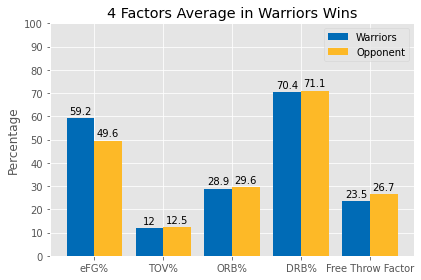

In [19]:
plt.style.use('ggplot')
labels = ['eFG%', 'TOV%', 'ORB%', 'DRB%', 'Free Throw Factor']
x = np.arange(len(labels))  # the label locations
width = 0.4  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, warriors_means, width, label= 'Warriors', color = '#006BB6')
rects2 = ax.bar(x + width/2, opp_means, width, label= 'Opponent', color = '#FDB927')

#y-axis label
ax.set_ylabel('Percentage')
# chart title
ax.set_title('4 Factors Average in Warriors Wins')
# x axis labels
ax.set_xticks(x)
#y axis labels
ax.set_yticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
ax.set_xticklabels(labels)
ax.bar_label(rects1, padding = 2)
ax.bar_label(rects2, padding = 2)
#display legend
ax.legend()



fig.tight_layout()

plt.show()


### Warriors Four Factors in Losses

We create our chart for the Warriors and Warriors' Opponents Performance in the Four Factors in the Warriors losses during the 2018-2019 season below!

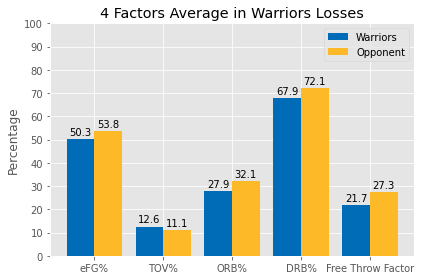

In [20]:
labels2 = ['eFG%', 'TOV%', 'ORB%', 'DRB%', 'Free Throw Factor']
x = np.arange(len(labels))  # the label locations
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, warriors_means2, width, label='Warriors', color = '#006BB6')
rects2 = ax.bar(x + width/2, opp_means2, width, label='Opponent', color = '#FDB927')

ax.set_ylabel('Percentage')
ax.set_title('4 Factors Average in Warriors Losses')
ax.set_xticks(x)
ax.set_yticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
ax.set_xticklabels(labels2)
ax.bar_label(rects1, padding = 2)
ax.bar_label(rects2, padding = 2)
ax.legend()

fig.tight_layout()
plt.show()

### Difference of Four Factors in Warriors Wins and Losses

We create our chart for the Difference in Four Factor Performance in Warriors wins and losses during the 2018-2019 season below! We can see the biggest points that factor into Warriors' victories and losses!

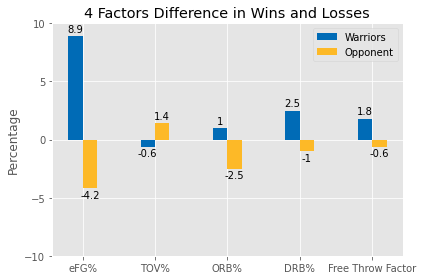

In [21]:
warriors_diff = [0,0,0,0,0]
opp_diff = [0,0,0,0,0]

width = .2
for i in range(5):
    warriors_diff[i] = round(warriors_means[i] - warriors_means2[i],2)
    opp_diff[i] = round(opp_means[i] - opp_means2[i],2)

labels3 = ['eFG%', 'TOV%', 'ORB%', 'DRB%', 'Free Throw Factor']
x = np.arange(len(labels))  # the label locations
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, warriors_diff, width, label='Warriors', color = '#006BB6')
rects2 = ax.bar(x + width/2, opp_diff, width, label='Opponent', color = '#FDB927')

ax.set_ylabel('Percentage')
ax.set_title('4 Factors Difference in Wins and Losses')
ax.set_xticks(x)
ax.set_yticks([-10,-5,0,5,10])
ax.set_xticklabels(labels2)
ax.bar_label(rects1, padding = 2)
ax.bar_label(rects2, padding = 2)
ax.legend()


fig.tight_layout()
plt.show()


As we can see in our chart, the biggest differences in the Warriors wins and losses happen to be in Efficient Field Goal Percentage category. We can conclude that the biggest factor in the Warriors winning and losing was their shooting performance. However, it is easy to see that the Warriors perform better in every single category in their wins, and their opponents do worse in the four factor categories in losses. The impact of the four factors on the outcome of games can be easily seen in this graph!

What can we do with this information? Whether you're working in the Warriors front office or a fan watching TV, being able to interpret statistics behind the game of basketball leads to methods of team performance improvement and a better understanding of the sport!

# Conclusion

Thank you for taking the time to read my tutorial on using Python to analyze NBA play-by-play datasets through data science methods! If you're interesting in exploring more about NBA analytics and play-by-play datasets, check out these websites!

EightThirtyFour NBA Play-By-Play Datasets and Info: https://eightthirtyfour.com/data

Kaggle NBA Play-By Play Dataset: https://www.kaggle.com/schmadam97/nba-playbyplay-data-20182019

New Advanced Stats Provided by NBA CourtOptix: https://www.nba.com/news/nba-courtoptix

NBA Data Science Articles: https://towardsdatascience.com/tagged/nba